# Run Pixel Classifier on a Test Sites
Note: The script `nn_predict.py` also works well for this purpose if evaluating a single site.

This functionality is also contained within the `train_pixel_classifier` notebook for the purposes of evaluating a trained model.

In [1]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_pixel_vectors
from scripts.viz_tools import stretch_histogram, normalize

In [2]:
def make_predictions(model_path, data, site_name, threshold):
    test_image = data
    model = keras.models.load_model(model_path)

    rgb_stack = []
    preds_stack = []
    threshold_stack = []
    print("Making Predictions")
    for month in list(test_image.keys()):
        test_pixel_vectors, width, height = get_pixel_vectors(test_image, month)
        if width > 0:
            test_pixel_vectors = normalize(test_pixel_vectors)

            r = np.reshape(np.array(test_pixel_vectors)[:,3], (width, height))
            g = np.reshape(np.array(test_pixel_vectors)[:,2], (width, height))
            b = np.reshape(np.array(test_pixel_vectors)[:,1], (width, height))
            rgb = np.stack((r,g,b), axis=-1)
            rgb_stack.append(rgb)

            preds = model.predict(np.expand_dims(test_pixel_vectors, axis=-1))
            preds_img = np.reshape(preds, (width, height, 2))[:,:,1]
            preds_stack.append(preds_img)

            thresh_img = np.clip(preds_img, threshold, 1)
            threshold_stack.append(thresh_img)
            
    rgb_median = np.median(rgb_stack, axis=0)
    preds_median = np.median(preds_stack, axis=0)
    threshold_median = np.median(threshold_stack, axis=0)

    plt.figure(dpi=150, facecolor=(1,1,1), figsize=(15,5))

    plt.subplot(1,3,1)
    
    adjusted_image = stretch_histogram(rgb_median)
    plt.imshow(adjusted_image)
    plt.title(f'{site_name} Median', size=8)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(preds_median, vmin=0, vmax=1, cmap='seismic')
    plt.title('Classification Median', size=8)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(threshold_median, cmap='gray')
    plt.title(f"Positive Pixels Median: Threshold {threshold}", size=8)
    plt.axis('off')

    title = f"{site_name} - Median Values - Neural Network Classification - Threshold {threshold}"
    plt.suptitle(title, y=1.01)
    plt.tight_layout()
    #plt.savefig(os.path.join(output_dir, title + '.png'), bbox_inches='tight')
    plt.show()
    
    return rgb_stack, preds_stack, threshold_stack

### Download a test patch

In [4]:
rect_width = 0.0075
coords = [115.16987454393899, -8.091076190191433]
num_months = 3
start_date = '2020-01-01'
name = 'TPA Bengkala'
patch_history = get_history([coords], 
                            [name], 
                            rect_width,
                            num_months=num_months,
                            start_date=start_date,
                            cloud_mask=True)

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:02<00:04,  2.46s/it]

 67%|██████▋   | 2/3 [00:04<00:02,  2.36s/it]

100%|██████████| 3/3 [00:06<00:00,  2.26s/it]


### Show composite predictions

Making Predictions


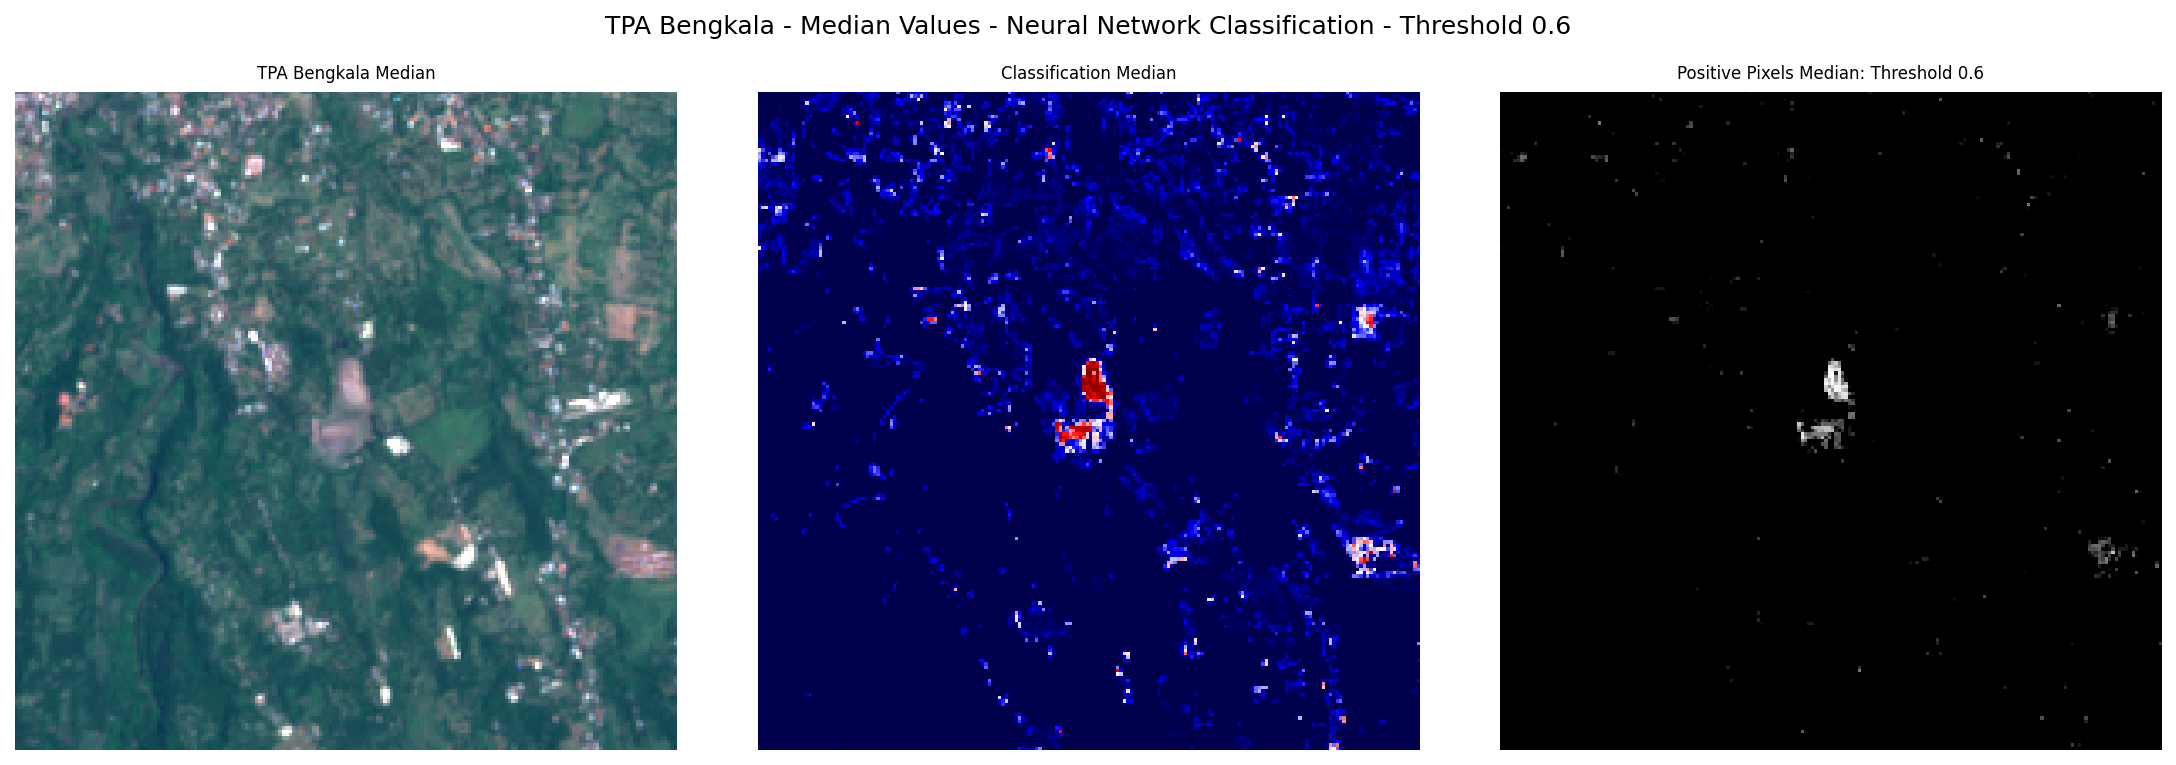

In [5]:
threshold = 0.6
model_path = '../models/pipeline_validation_model_3-15-21.h5'
rgb_stack, pred_stack, threshold_stack = make_predictions(model_path, patch_history, name, threshold)

### Show timeseries predictions

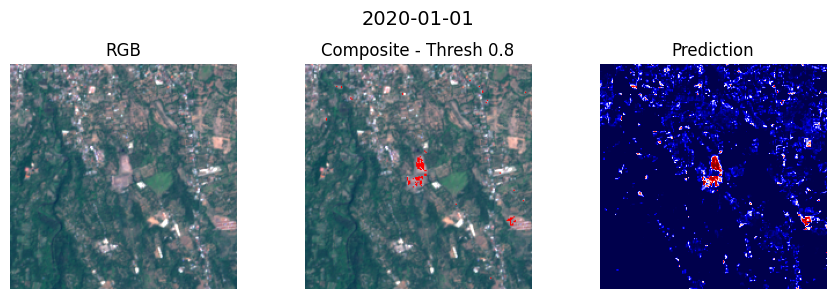

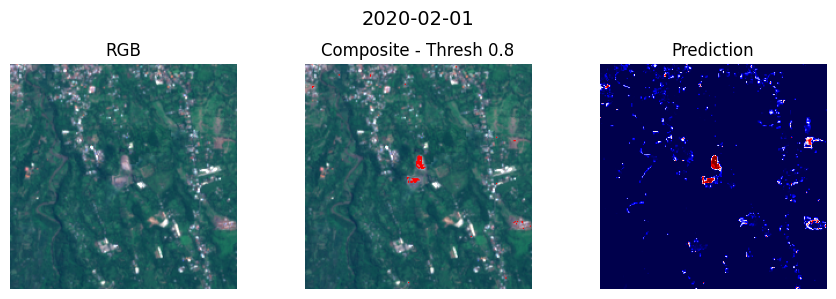

In [6]:
threshold = 0.8

for image, pred, date in zip(rgb_stack, pred_stack, list(patch_history.keys())):
    plt.figure(figsize=(9,3), facecolor=(1,1,1), dpi=100)
    plt.subplot(1,3,1)
    plt.imshow(np.clip(stretch_histogram(image), 0, 1))
    plt.axis('off')
    plt.title('RGB')
    
    plt.subplot(1,3,2)
    combo = stretch_histogram(np.copy(image))
    combo[:,:,0][np.ma.masked_greater(pred, threshold).mask] = 1
    combo[:,:,1][np.ma.masked_greater(pred, threshold).mask] = 0
    combo[:,:,2][np.ma.masked_greater(pred, threshold).mask] = 0
    plt.imshow(combo)
    plt.axis('off')
    plt.title(f'Composite - Thresh {threshold}')
    
    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='seismic')
    plt.title('Prediction')
    plt.axis('off')
    
    plt.suptitle(date, size=14)
    plt.tight_layout()
    plt.show()